In [223]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Downsampled MNIST tensor shape: torch.Size([14, 14])


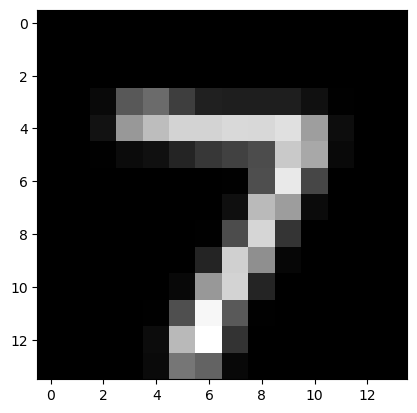

In [225]:
# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

In [227]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader, device = device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [229]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

###############################
# 1. Dataset: Neuron-level Graph Representation
###############################
class MLPGraphDatasetNeurons(torch.utils.data.Dataset):
    def __init__(self, model_folder):
        # Collect all .pt files in the folder.
        self.model_paths = [os.path.join(model_folder, fname) 
                            for fname in os.listdir(model_folder) if fname.endswith('.pt')]

    def __len__(self):
        return len(self.model_paths)

    def __getitem__(self, idx):
        # Each file stores (weights, biases) using weights_only=True.
        weights, biases = torch.load(self.model_paths[idx], weights_only=True)
        # --- Build Node Features ---
        # Input layer: use the input dimension from the first weight matrix.
        input_dim = weights[0].shape[1]
        input_feats = torch.zeros(input_dim, 1)
        node_features = [input_feats]
        for b in biases:
            # Each bias is a 1D tensor; reshape it as a column vector.
            node_feats = b.view(-1, 1)
            node_features.append(node_feats)
        x = torch.cat(node_features, dim=0)

        # --- Build Edges and Edge Attributes ---
        edge_index_list = []
        edge_attr_list = []
        offset = 0  # starting index for current layer's nodes
        for w in weights:
            in_dim = w.shape[1]    # nodes in source layer
            out_dim = w.shape[0]   # nodes in destination layer
            src_offset = offset
            dst_offset = offset + in_dim
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = src_offset + j_in
                    dst = dst_offset + i_out
                    edge_index_list.append([src, dst])
                    edge_attr_list.append([w[i_out, j_in].item()])
            offset += in_dim
        # Convert lists into tensors.
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


def vgae_to_mlp(generated_data):
    """
    generated_data: a Data object that has the reconstructed node features (x)
    and edge attributes (edge_attr).  
    The original graph was built as:
      - First 196 nodes: input layer,
      - Next 32 nodes: fc1 neurons,
      - Next 32 nodes: fc2 neurons,
      - Next 10 nodes: fc3 neurons.
    Edge ordering is:
      - fc1: edges from input (196 nodes) to fc1 (32 nodes) in a nested loop:
             for i in range(32): for j in range(196)
      - fc2: edges from fc1 (32 nodes) to fc2 (32 nodes)
      - fc3: edges from fc2 (32 nodes) to fc3 (10 nodes)
    This function instantiates a new MLP and sets its weights and biases from the generated outputs.
    """
    x_rec = generated_data.x.squeeze()  # shape: (196+32+32+10,)
    edge_attr_rec = generated_data.edge_attr  # shape: (32*196 + 32*32 + 10*32,)

    # Extract biases.
    fc1_bias = x_rec[196:196+32]
    fc2_bias = x_rec[196+32:196+32+32]
    fc3_bias = x_rec[196+32+32:196+32+32+10]

    # Extract edge weights.
    # For fc1: first 32*196 values.
    fc1_weight = edge_attr_rec[:32*196].view(32, 196)
    # For fc2: next 32*32 values.
    start_fc2 = 32*196
    fc2_weight = edge_attr_rec[start_fc2:start_fc2+32*32].view(32, 32)
    # For fc3: remaining 10*32 values.
    start_fc3 = start_fc2 + 32*32
    fc3_weight = edge_attr_rec[start_fc3:start_fc3+10*32].view(10, 32)

    # Create a new instance of the MLP.
    new_mlp = MLP()
    # Assign weights and biases.
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp


In [233]:
from torch_geometric.nn import GCNConv, BatchNorm, JumpingKnowledge, GraphNorm, GATConv, GAT

class GraphBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mode = "max"):
        super().__init__()
        
        self.mode = mode
        
        self.gc1 = GCNConv(in_channels, in_channels)
        self.gc2 = GCNConv(in_channels, in_channels)
        self.gc3 = GCNConv(in_channels, in_channels)

        self.jk = JumpingKnowledge(mode = mode)

        self.gn1 = GraphNorm(in_channels) # mode != max broken atm 
        
        self.out = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        acts = []

        h1 = F.elu(self.gc1(x, edge_index, edge_weight))
        acts.append(h1)

        h2 = F.elu(self.gc2(h1, edge_index, edge_weight))
        acts.append(h2)

        h3 = F.elu(self.gc3(h2, edge_index, edge_weight))
        acts.append(h3)

        h4 = F.elu(self.jk(acts))
        h5 = self.gn1(h4)

        out = F.elu(self.out(h5, edge_index, edge_weight))
        
        return out

###############################
# 2. Encoder: GCN-based with Edge Weight Processing
###############################
class GCNEncoderEdge(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(GCNEncoderEdge, self).__init__()
        
        # self.gat = GAT(1, 1, 3, 1) 
        self.gat = GATConv(1, 1)
        
        self.conv1 = GraphBlock(in_channels, hidden_channels)
        self.out = GCNConv(hidden_channels, 2 * latent_dim)

    def forward(self, x, edge_index, edge_weight):
    
        # Pass edge_weight and apply ReLU.
        gat = self.gat(x, edge_index, edge_weight)
        x = self.conv1(gat, edge_index, edge_weight)
        out = self.out(x, edge_index, edge_weight)
        
        mu, logvar = torch.chunk(out, 2, dim=1)

        return mu, logvar

###############################
# 3. Decoders:
#   (a) EdgeDecoderMLP: Takes concatenated latent vectors of source & target
#       and predicts the edge weight.
#   (b) NodeDecoderMLP: Decodes each node latent vector into a reconstructed
#       node feature (here, the neuron bias).
###############################
class EdgeDecoderMLP(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super(EdgeDecoderMLP, self).__init__()
        self.fc1 = nn.Linear(latent_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)


    def forward(self, z, edge_index):

        
        # Get the latent representations for source and target nodes.
        z_src = z[edge_index[0]]
        z_dst = z[edge_index[1]]
        
        # Concatenate the source and destination latent vectors.
        z_cat = torch.cat([z_src, z_dst], dim=1)
        
        h1 = F.relu(self.fc1(z_cat))
        h2 = F.relu(self.fc2(h1))
        out = self.fc3(h2)
        
        return out.squeeze()  # shape: (num_edges,)

class NodeDecoderMLP(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64, out_dim=1):
        super(NodeDecoderMLP, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, out_dim)

    def forward(self, z, edge_index):
        h1 = F.relu(self.fc1( z ))
        h2 = F.relu(self.fc2(h1))
        out = self.fc3(h2)

        return out.squeeze()  # shape: (num_nodes,)

###############################
# 4. Full VGAE Model (Generative Network)
###############################
class CustomVGAE(nn.Module):
    def __init__(self, encoder, edge_decoder, node_decoder, kl_weight=1e-3):
        super(CustomVGAE, self).__init__()
        self.encoder = encoder
        self.edge_decoder = edge_decoder
        self.node_decoder = node_decoder
        self.kl_weight = kl_weight

    def encode(self, x, edge_index, edge_weight):
        mu, logvar = self.encoder(x, edge_index, edge_weight)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Clamp logvar to avoid extreme values.
#         logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar) + 1e-8
        if self.training:
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode_edges(self, z, edge_index):
        return self.edge_decoder(z, edge_index)

    def decode_nodes(self, z, edge_index):
        return self.node_decoder(z, edge_index)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr.view(-1)
        mu, logvar = self.encode(x, edge_index, edge_weight)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def compute_loss(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr.view(-1)
        mu, logvar = self.encode(x, edge_index, edge_weight)
        z = self.reparameterize( torch.nan_to_num(mu), torch.nan_to_num(logvar) )
        # z = torch.nan_to_num(z)
        # print(f"Z shape: {z.shape} n/ Z: {z}")
        
        # Decode edges and nodes.
        pred_edge_weight = self.decode_edges(z, edge_index)
        pred_node_features = self.decode_nodes(z, edge_index)
        # print(f"Pred weights: {pred_edge_weight}, pred nodes: {pred_node_features}")
        
        # Reconstruction losses.
        loss_edge = F.mse_loss(pred_edge_weight, edge_weight) + 1e-8
        # print(f"Edge loss: {loss_edge}")
        
        # Data.x is of shape (num_nodes,1), so squeeze to match (num_nodes,)
        loss_node = F.mse_loss(pred_node_features, x.squeeze()) + 1e-8
        # print(f"Node loss: {loss_node}")
        
        # KL divergence loss, averaged over nodes.
        kl_loss = -0.5 * torch.mean(torch.sum(1 + torch.nan_to_num(logvar) - torch.nan_to_num(mu).pow(2) - torch.exp(torch.nan_to_num(logvar)) + 1e-8, dim=1))
        # print(f"KL loss: {kl_loss}")
        
        return loss_edge + loss_node + self.kl_weight * kl_loss


In [235]:
###############################
# 6. Setting Up DataLoader and Training
###############################
dataset = MLPGraphDatasetNeurons("models")
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Hyperparameters.
in_channels = 1          # Each node feature is one scalar.
hidden_channels = 1
latent_dim = 512
hidden_dim = 2048
learning_rate = 1e-3

# Instantiate components.
encoder = GCNEncoderEdge(in_channels, hidden_channels, latent_dim)
edge_decoder = EdgeDecoderMLP(latent_dim, hidden_dim=hidden_dim)
node_decoder = NodeDecoderMLP(latent_dim, hidden_dim=hidden_dim, out_dim=in_channels)
model = CustomVGAE(encoder, edge_decoder, node_decoder, kl_weight=1e-3)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

###############################
# 7. Training Loop
###############################
def train():
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        loss = model.compute_loss(data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

num_epochs = 5
for epoch in range(1, num_epochs + 1):
    loss = train()
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")


Epoch 001, Loss: 33.4938
Epoch 002, Loss: 4.1251
Epoch 003, Loss: 1.3073
Epoch 004, Loss: 0.1684
Epoch 005, Loss: 0.0506


In [236]:
def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

print(f"VGAE has {count_parameters(model)} parameters")

VGAE has 11548689 parameters


In [237]:
###############################
# 8. Testing the Converted MLP on MNIST Data
###############################
# Assume you have a test_mlp function defined as:
# def test_mlp(mlp, device, test_loader): ...
#
# After training, you can run the VGAE over one graph, decode, and convert the output to an MLP.
# For example:
#
model.eval()
data = dataset[0]  # take one example
with torch.no_grad():
  z, mu, logvar = model(data)
  rec_edge = model.edge_decoder(z, data.edge_index)
  rec_node = model.node_decoder(z, data.edge_index)

# Build a new Data object with the reconstructed node features and edge attributes:
rec_data = Data(x=rec_node.unsqueeze(1), edge_index=data.edge_index, edge_attr=rec_edge.unsqueeze(1))
# Convert to an MLP.
generated_mlp = vgae_to_mlp(rec_data)

# Then, test with:
test_mlp(generated_mlp, test_loader)


9.8

In [243]:
model.eval()
scores = []
n = 5
for i in range(n):
    data = dataset[n]  # take one example
    with torch.no_grad():
      z, mu, logvar = model(data)
      rec_edge = model.edge_decoder(z, data.edge_index)
      rec_node = model.node_decoder(z, data.edge_index)
    
    # Build a new Data object with the reconstructed node features and edge attributes:
    rec_data = Data(x=rec_node.unsqueeze(1), edge_index=data.edge_index, edge_attr=rec_edge.unsqueeze(1))
    # Convert to an MLP.
    generated_mlp = vgae_to_mlp(rec_data)
    
    # Then, test with:
    score = test_mlp(generated_mlp, test_loader)
    scores.append(score)



In [244]:
print(scores)

[9.8, 9.8, 9.8, 9.8, 9.8]


In [245]:
test = next(iter(loader))


In [246]:
test

DataBatch(x=[8640, 1], edge_index=[2, 243712], edge_attr=[243712, 1], batch=[8640], ptr=[33])